# LAMPIRAN #01 - "CONVOLUTIONAL NEURAL NETWORK"

dataset - dapat diunduh di https://archive.ics.uci.edu/dataset/481/emg+data+for+gestures

Program ini akan berjalan seperti berikut:
* Import semua library python yang diperlukan
* Menghubungkan ke GDrive (semua data tersimpan di GDrive).
* Melakukan K-Fold Cross Valtidation (10 folds dengan 5 files tiap foldsnya).
* Membaca dan Proses semua file (50 file raw data) (load, clustering, separate class dan data).
* Menyiapkan dataframe yang sudah diproses menjadi torch datasets.
* Mebuat dataloader (validasi dan training) dan padding datasetsnya agar memiliki panjang sequential yang sama.
* Melakukan proses training model dengan menggunakan CrossEntropyLoss sebagai Fungsi Loss dan menggunakan algoritma SGD untuk optimasi model dengan learning rate (lr) awal sebesar 0.3 dan dilakukan penyesuaian learning rate dengan menggunakan REDUCELRONPLATEAU, yaitu proses penyesuaian lr jika nilai loss evaluasi tidak berkurang lagi setelah 1 proses epoch dengan redaksi 0.5.
* Plot nilai Akurasi dan Loss dari hasil latih model tiap K-Folds nya.
* Menyimpan Akurasi dan Loss dari hasil evaluasi model akhir.
* Menampilkan Confusion matrik hasil dari evaluasi model untuk analisis lebih lanjut.
* Menghitung hasil akurasi keseluruhan model.

# Code berikut untuk menambah limit line dari Output Cell di G-Colab menjadi 50000 line.

In [ ]:
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 50000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

# 1. IMPORT LIBRARIES
* Pandas -> pip install pandas || pip3 install pandas : https://pandas.pydata.org/pandas-docs/stable/getting_started/install.html
* NumPy -> pip install numpy || pip3 install numpy : https://numpy.org/install/
* os - sudah terinstall secara otomatis.
* random - sudah terinstall secara otomatis.
* pickle - sudah terinstall secara otomatis.
* Matplotlib - pip install matplotlib || pip3 install matplotlib : https://matplotlib.org/stable/users/installing/index.html
* PyTorch - instal melalui Command dari: https://pytorch.org/get-started/locally/

In [ ]:
import pandas as pd
import numpy as np
import os
import random
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

<IPython.core.display.Javascript object>

# 2. Mendefinisikan Fungsi - Fungsi yang digunakan.

## DataProcessor - Mendefinisikan fungsi untuk memproses file
* fungsi read_files -> membaca dan menggabungkan semua file (.txt) dan merubahnya menjadi Pandas DataFrame.
* fungsi cluster_cluster_class_data -> untuk mengelompokkan kumpulan data dengan class atau labelnya.
* fungsi separate_class_data -> memisahkan dataframe menjadi data dan class.

In [ ]:
class DataProcessor:
    def __init__(self, lokasi_data):
        self.lokasi_data = lokasi_data

    def read_files(self, data_list):
        combined_result = []

        for nama in data_list:
            data = pd.read_table(self.lokasi_data + nama)
            del data['time']
            data = data[data['class'] > 0]
            Data = data
            Data['class'] = data['class'] - 1
            Data.reset_index(inplace=True)
            dataframes = self.cluster_class_data(Data)
            df_list = self.separate_class_data(dataframes)

            combined_result.extend(df_list)

        return combined_result

    def cluster_class_data(self, dataframe):
        dataframes = []
        current_class = None
        start_index = 0

        for index, row in dataframe.iterrows():
            if current_class is None or current_class != row['class']:
                if current_class is not None:
                    dataframes.append(dataframe.iloc[start_index:index])
                current_class = row['class']
                start_index = index

        dataframes.append(dataframe.iloc[start_index:])

        return dataframes

    def separate_class_data(self, dataframes):
        df_list = []

        for df in dataframes:
            class_value = int(df['class'].mode().iloc[0])
            data = df.iloc[:, 1:9].values
            # Swap the axes of the data array
            data_swapped = np.swapaxes(data, 0, 1)

            df_list.append({"class": class_value, "data": data_swapped})
            #df_list.append({"class": class_value, "data": data})

        return df_list

<IPython.core.display.Javascript object>

## CustomDataset - Membuat Custom Torch dataset agar bisa menjadi masukan Model.
* Konversi tipe class menjadi tensor long.
* Konversi tipe data menjadi tensor float32.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        sample = self.data_list[idx]
        data = sample['data']
        return torch.tensor(data, dtype=torch.float32), torch.tensor(sample['class'], dtype=torch.long)

<IPython.core.display.Javascript object>

## my_collate_fn - untuk menyamakan panjang sequensial data yang menjadi dataloader.
* Melakukan Padding dengan value 0 diakhir data agar memiliki panjang sequensial data yang sama.
* * Ex. Jika dalam dalam 1 batch terdapat 4 dataset dengan panjang sequensial yang berbeda, maka semua dataset dengan panjang sequensial paling kecil akan dilakukan padding dengan value 0 agar memiliki panjang sequential yang sama sehingga bisa diproses lebih lanjur menjadi *input* model.
** * Ex. jika terdapat 4 dataset dengan masih masing bentuknya adalah [1, 4] , [1, 5], [1, 4], [1, 6]. maka 3 dataset dengan bentuk paling kecil akan disamakan bentuknya dengan dataset bentuk paling besar dengan menambahkan item dengan nilai 0 pada bagian akhir sequensial data, misal untuk data pertama dengan bentuk [1, 4] adalah (0, 2, 1, 1) maka dia akan berubah menjadi (0, 2, 1, 1, 0, 0) setelah dilakukan proses padding. sehingga 4 dataset menjadi [1, 6], [1, 6], [1, 6], [1, 6].
* * Metode padding digunakan untuk mengurangi hilangnya karakteristik data yang terlalu signifikan.

In [ ]:
def my_collate_fn(batch):
    data, target = zip(*batch)

    # Find the maximum length along axis 1
    max_length = max(d.shape[1] for d in data)

    # Pad the tensors manually along axis 1
    data_padded = []
    for d in data:
        pad_width = max_length - d.shape[1]
        padded_tensor = torch.cat([d, torch.zeros((d.shape[0], pad_width))], dim=1)
        data_padded.append(padded_tensor)

    data_padded = torch.stack(data_padded)  # Convert list to a tensor
    target = torch.tensor(target)
    return data_padded, target

<IPython.core.display.Javascript object>

## Model CNN

Model CNN ini akan memiliki arsitektur sebagai berikut:
* Bagian Convolusi - menggunakan conv1d untuk mengatasi data sequential (menghasilkan 32 feature maps dari 8 input channel)
** BatchNorm1d (menormalisasi batch untuk mengurangi penggunaan memori)
** ReLU (layer non-linear)
* Bagian Pooling:
** Global Pooling yang digunakan adalah AdaptiveMaxPool1d, AdaptiveMaxPool1d digunakan untuk menyederhanakan output dari layer Convolusi dan non-linear menjadi bentuk yang diinginkan agar lebih mudah menjadi masukan untuk layer fully connect atau layer klasifikasi, dalam hal ini bentuk *output* dari Global Pooling ini akan memiliki bentuk 32.
* Layer fully connect atau layer clasifikasi
** fungsi Linear dari 32 * 32 (bentuk input dari hasil Pooling) menjadi 128.
** fungsi aktivasi ReLU.
** Dropout(0.25).
** fungsi Linear dari 128 menjadi 64.
** fungsi aktivasi ReLU.
** fungsi Linear dari 64 menjadi 32.
** fungsi aktivasi ReLU.
** fungsi Linear dari 32 menjadi 16.
** fungsi aktivasi ReLU.
** fungsi Linear dari 16 menjadi 6, karena data yang digunakan memiliki 6 class.

In [ ]:
class VariableCNN(nn.Module):
    def __init__(self):
        super(VariableCNN, self).__init__()
        self.conv01 = nn.Sequential(
            nn.Conv1d(8, 32, kernel_size = 3, padding = 2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
        )

        self.fc = nn.Sequential(
            nn.Linear(32 * 32, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )
        self.Classifikasi = nn.Sequential(
            nn.Linear(16, 6),
        ) # dengan output 6 class

        self.flat = nn.Flatten()
        self.globmaxpool = nn.AdaptiveMaxPool1d(32)

    def forward(self, x):
        x = self.conv01(x)
        x = self.globmaxpool(x)
        x = self.flat(x)
        x = self.fc(x)
        x = self.Classifikasi(x)

        return x

<IPython.core.display.Javascript object>

## train_eval_model - untuk melakukan training dan evaluasi model.
* model akan dilatih dengan menggunakan algoritma sebagai berikut:
** load nilai data dan class model dalam dataloader.
** data akan dimasukkan kedalam model untuk dipelajari oleh model.
** hasil dari model yang dilatih kemudian dilakukan perhitungan torch.argmax untuk mencari index dari nilai terbesar (maksimal) dari suatu tensor.
** * Ex 1. bentuk dari *output* model ini adalah tensor dengan bentuk (Batch, 6). kemudan akan dilakukan perhitungan argmax pada dimensi 1 (tiap rows) sehingga hasil dari prediksi adalah sebuat tensor 1d atau tensor vektor berukuran batch.
** * Ex 2. jika hasil tensor *output* model adalah tensor([[3, 1, 4],[5, 2, 0]]). atau tensor 2*3 dengan 2 rows dan 3 colom, jika dilakukan perhitungan argmax untuk dimensi 1 atau tiap rows, maka untuk row pertama nilai maksimal adalah 4 dengan posisi index adalah 2, untuk row kedua nilai terbesar adalah 5 dengan posisi index adalah 0, sehingga *output* nya adalah [2, 0].
** kemudian dilakukan perhitungan Loss dari prediksi model, dengan cara membandingkan value dari hasil prediksi dan value dari nilai aktual.
** * untuk perhitungan nilai Loss ini menggunakan CrossEntropyLoss
** kemudian nilai gradient dari model akan kembali di-nol kan dengan optimasi zero_grad.
** akhirnya dilakukan proses back-propagation untuk optimasi nilai Loss agar nilai Loss mendekati 0.
** dilakukan pula hal yang sama untuk evaluasi model.
** setelah dilakukan evaluasi nilai loss dari hasil evaluasi model akan dijarikan pedoman untuk optimasi atau penyesuaian nilai learning rate dari model, jika nilai loss lebih besar dari nilai loss yang sebelumnya, maka nilai learning ratenya akan disesuaikan.
* Hasil dari fungsi ini adalah nilai akhir akurasi dan loss dari evaluasi model.

In [ ]:
def train_eval_model(model, criterion, optimizer, num_epochs, batch_size, device):
    min_train_loss = np.inf
    min_train_acc = 0.0
    tr_loss = np.zeros((num_epochs))
    acc_train = np.zeros((num_epochs))

    training_dataloader = DataLoader(CustomDataset_training, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)

    for epoch in range(num_epochs):
        model.train()

        acc_all_train = []
        train_loss = []

        for x, y in training_dataloader:
            output = model(x.to(device))

            pred = torch.argmax(output, dim=1)
            acc_all_train.append(100 * (pred == y.to(device)).float().mean())

            loss = criterion(output, y.to(device))
            train_loss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()

        acc_all_test = []
        test_loss = []

        with torch.no_grad():
            for x, yt in validasi_dataloader:
                output = model(x.to(device))

                preds = torch.argmax(output, dim=1)
                acc_all_test.append(100 * (preds == yt.to(device)).float().mean())

                loss = criterion(output, yt.to(device))
                test_loss.append(loss.item())

        test_loss = torch.tensor(test_loss)
        acc_all_test = torch.tensor(acc_all_test)

        avg_test_loss = test_loss.mean().item()
        avg_test_acc = acc_all_test.mean().item()

        pickle.dump(preds, open('acc_test.dump', 'wb'))
        pickle.dump(yt, open('test_target.dump', 'wb'))

        #scheduler step
        scheduler.step(test_loss)

        train_loss = torch.tensor(train_loss)
        tr_loss[epoch] = train_loss.mean()
        acc_all_train = torch.tensor(acc_all_train)
        acc_train[epoch] = acc_all_train.mean()

        pickle.dump(tr_loss, open('tr_loss.dump', 'wb'))
        pickle.dump(acc_train, open('acc_train.dump', 'wb'))

        print("Training model ... ({}/{}) \t Akurasi/Loss : {:.2f} % / {:.5f} || Evaluasi model Akurasi/Loss : {:.2f} % / {:.5f}".format(
            epoch+1, num_epochs,
            acc_train[epoch], tr_loss[epoch],
            avg_test_acc, avg_test_loss
        ))

    print(f'Trainig model Complated ... ({epoch+1}/{num_epochs}) \n')

    return avg_test_loss, avg_test_acc

<IPython.core.display.Javascript object>

## plot_loss_akurasi - Untuk ploting akurasi dan nilai loss model selama masa latih model.

In [ ]:
def plot_loss_akurasi(num_epochs):
  tr_loss = pickle.load(open('tr_loss.dump', 'rb'))
  acc_train = pickle.load(open('acc_train.dump', 'rb'))
  nama = list(labels)

  plt.close('all')
  fig = plt.figure(figsize=(8, 3))

  plt.subplot(121)
  x = np.array(range(1, num_epochs+1))
  plt.plot(x, acc_train, label = 'Train')
  plt.xlabel('Epochs')
  plt.ylabel('Akurasi (%)')
  plt.title(f'AKURASI TRAINING FOLD KE - {fold+1}')
  plt.grid()
  plt.legend()

  plt.subplot(122)
  plt.plot(x, tr_loss, label = 'Train')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(f'LOSS TRAINING FOLD KE - {fold+1}')
  plt.grid()
  plt.legend()

  plt.tight_layout()

  return plt.show()

<IPython.core.display.Javascript object>

## matrix - fungsi untuk menampilkan confusion matrix dari hasil evaluasi model.

In [ ]:
def matrix():
  acc_test = pickle.load(open('acc_test.dump', 'rb')).to(device)
  test_target = pickle.load(open('test_target.dump', 'rb')).to(device)

  y_real = pd.Series(test_target.cpu().numpy(), name = "Actual")
  y_pred = pd.Series(acc_test.cpu().numpy(), name = "Predicted")

  confusion_matrix = pd.crosstab(y_real, y_pred)
  return print(confusion_matrix)

<IPython.core.display.Javascript object>

# 3. MENGHUBUNGKAN KE GDRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

<IPython.core.display.Javascript object>

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Mendefinisikan lokasi file

In [ ]:
lokasi_data = r"/content/drive/MyDrive/Data/data_emg/datasets/"
files = os.listdir(lokasi_data)
datasets = [f for f in files if os.path.isfile(lokasi_data+'/'+f)]
#random.shuffle(datasets)

<IPython.core.display.Javascript object>

## Monitoring file - file yang digunakan.

In [ ]:
print(f'jumlah file yang digunakan : {len(datasets)}')
for i in datasets:
  print(i)

<IPython.core.display.Javascript object>

jumlah file yang digunakan : 50
2_raw_data_10-29_30.03.16.txt
2_raw_data_12-39_28.03.16.txt
1_raw_data_11-15_11.04.16.txt
1_raw_data_13-12_22.03.16.txt
1_raw_data_13-26_21.03.16.txt
2_raw_data_09-51_15.04.16.txt
1_raw_data_12-12_25.04.16.txt
1_raw_data_10-38_11.04.16.txt
1_raw_data_12-10_15.04.16.txt
2_raw_data_14-21_22.03.16.txt
2_raw_data_12-37_21.03.16.txt
2_raw_data_14-53_24.04.16.txt
1_raw_data_10-03_13.04.16.txt
2_raw_data_13-19_05.04.16.txt
1_raw_data_11-19_23.03.16.txt
2_raw_data_13-29_21.03.16.txt
1_raw_data_09-49_12.04.16.txt
2_raw_data_11-20_23.03.16.txt
2_raw_data_11-16_11.04.16.txt
2_raw_data_12-43_23.03.16.txt
2_raw_data_11-10_21.03.16.txt
2_raw_data_13-04_15.04.16.txt
2_raw_data_09-34_11.04.16.txt
1_raw_data_11-35_28.03.16.txt
1_raw_data_10-17_15.04.16.txt
1_raw_data_12-14_23.03.16.txt
2_raw_data_12-16_23.03.16.txt
1_raw_data_11-08_21.03.16.txt
1_raw_data_18-48_22.03.16.txt
1_raw_data_13-18_05.04.16.txt
2_raw_data_10-18_15.04.16.txt
2_raw_data_12-20_06.04.16.txt
2_raw_da

# 4. Proses pembuatan K-Fold, Proses data, Membuat Custom dataset, Membuat dataloader, Training dan Evaliuasi model, plot progres training model (akurasi dan loss), confusion matrix hasil evaluasi dan nilai akurasi dan loss evaluasi model, performa rata - rata model.
* Pembuatan K-Folds.
** Terdapat 10 folds dengan 5 files tiap foldsnya.
** Evaluasi 10% dari total files dan Training 90% dari total files.
* Membuat Custom dataset.
** Memproses Evaluasi dan Training hingga menjadi Custom tensor Datasets.
* Membuat dataloader.
** Memproses datasets evaluasi dan training menjadi evaluasi_dataloader dan training_dataloader.
* Melakukan proses Training dan Evaluasi model.
* Ploting progres training model (akurasi dan loss tiap epochs).
* Confusion Matrix
** Membuat confusion matrix hasil dari evaluasi model.
** Menampilkan performa evaluasi model (akurasi dan loss)
* Performa rata - rata model.
** Menghitung nilai rereta hasil evaluasi model tiap fold nya (akurasi dan loss).

<IPython.core.display.Javascript object>

Total Validasi Class (5 files per K-Fold):
0    10
1    10
2    10
3    10
4    10
5    10
dtype: int64

 VariableCNN(
  (conv01): Sequential(
    (0): Conv1d(8, 32, kernel_size=(3,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=16, bias=True)
    (8): ReLU()
  )
  (Classifikasi): Sequential(
    (0): Linear(in_features=16, out_features=6, bias=True)
  )
  (flat): Flatten(start_dim=1, end_dim=-1)
  (globmaxpool): AdaptiveMaxPool1d(output_size=32)
)

K-Fold ... (1/10)
Training model ... (1/50) 	 Akurasi/Loss : 17.96 % / 1.79123 || Evaluasi model Akurasi/Loss : 16.67 

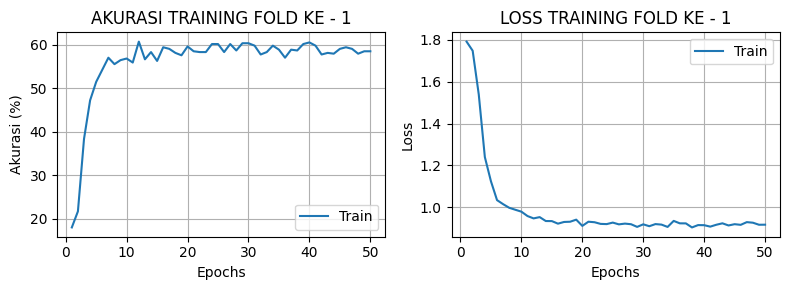



Predicted  0  1  2  3  4  5
Actual                     
0          8  0  2  0  0  0
1          0  2  0  0  0  8
2          1  1  4  0  0  4
3          0  0  0  8  2  0
4          0  2  0  5  3  0
5          0  2  2  0  1  5

Akurasi||Loss model : 50.00% || 0.99231 


K-Fold ... (2/10)
Training model ... (1/50) 	 Akurasi/Loss : 55.74 % / 0.96843 || Evaluasi model Akurasi/Loss : 21.67 % / 8.13075
Training model ... (2/50) 	 Akurasi/Loss : 57.96 % / 0.92672 || Evaluasi model Akurasi/Loss : 16.67 % / 8.75220
Training model ... (3/50) 	 Akurasi/Loss : 57.78 % / 0.87398 || Evaluasi model Akurasi/Loss : 25.00 % / 6.94767
Training model ... (4/50) 	 Akurasi/Loss : 59.81 % / 0.86446 || Evaluasi model Akurasi/Loss : 16.67 % / 8.38754
Training model ... (5/50) 	 Akurasi/Loss : 57.78 % / 0.84588 || Evaluasi model Akurasi/Loss : 16.67 % / 6.30184
Training model ... (6/50) 	 Akurasi/Loss : 61.11 % / 0.80272 || Evaluasi model Akurasi/Loss : 20.00 % / 4.07661
Training model ... (7/50) 	 Akurasi/Loss

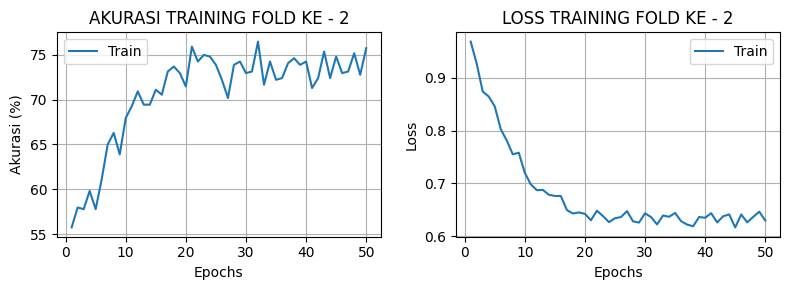



Predicted   0  1  2  3  4  5
Actual                      
0          10  0  0  0  0  0
1           0  6  0  0  2  2
2           1  0  8  0  0  1
3           0  0  0  8  2  0
4           0  1  0  3  6  0
5           0  2  3  0  0  5

Akurasi||Loss model : 71.67% || 0.66263 


K-Fold ... (3/10)
Training model ... (1/50) 	 Akurasi/Loss : 71.30 % / 0.70474 || Evaluasi model Akurasi/Loss : 16.67 % / 16.00508
Training model ... (2/50) 	 Akurasi/Loss : 72.78 % / 0.65860 || Evaluasi model Akurasi/Loss : 16.67 % / 11.73205
Training model ... (3/50) 	 Akurasi/Loss : 74.26 % / 0.63012 || Evaluasi model Akurasi/Loss : 16.67 % / 33.35274
Training model ... (4/50) 	 Akurasi/Loss : 76.85 % / 0.60318 || Evaluasi model Akurasi/Loss : 16.67 % / 8.58432
Training model ... (5/50) 	 Akurasi/Loss : 76.85 % / 0.58864 || Evaluasi model Akurasi/Loss : 16.67 % / 6.73469
Training model ... (6/50) 	 Akurasi/Loss : 78.89 % / 0.57822 || Evaluasi model Akurasi/Loss : 23.33 % / 9.94676
Training model ... (7/50) 	 A

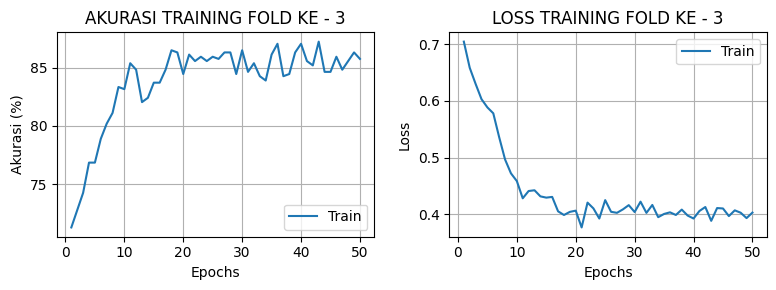



Predicted   0   1  2   3  4   5
Actual                         
0          10   0  0   0  0   0
1           0  10  0   0  0   0
2           0   0  9   0  0   1
3           0   0  0  10  0   0
4           1   0  0   1  8   0
5           0   0  0   0  0  10

Akurasi||Loss model : 95.00% || 0.18432 


K-Fold ... (4/10)
Training model ... (1/50) 	 Akurasi/Loss : 86.67 % / 0.39452 || Evaluasi model Akurasi/Loss : 23.33 % / 15.47268
Training model ... (2/50) 	 Akurasi/Loss : 85.00 % / 0.42004 || Evaluasi model Akurasi/Loss : 20.00 % / 7.64931
Training model ... (3/50) 	 Akurasi/Loss : 83.33 % / 0.42611 || Evaluasi model Akurasi/Loss : 20.00 % / 10.48533
Training model ... (4/50) 	 Akurasi/Loss : 84.44 % / 0.39453 || Evaluasi model Akurasi/Loss : 16.67 % / 19.56939
Training model ... (5/50) 	 Akurasi/Loss : 87.22 % / 0.35127 || Evaluasi model Akurasi/Loss : 33.33 % / 4.08746
Training model ... (6/50) 	 Akurasi/Loss : 85.56 % / 0.33262 || Evaluasi model Akurasi/Loss : 16.67 % / 6.12790
Train

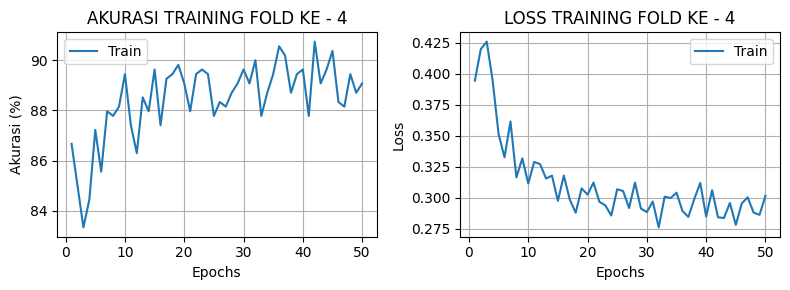



Predicted  0  1  2  3   4   5
Actual                       
0          9  0  0  0   0   1
1          0  9  1  0   0   0
2          1  1  8  0   0   0
3          0  0  0  9   1   0
4          0  0  0  0  10   0
5          0  0  0  0   0  10

Akurasi||Loss model : 91.67% || 0.28554 


K-Fold ... (5/10)
Training model ... (1/50) 	 Akurasi/Loss : 85.56 % / 0.37210 || Evaluasi model Akurasi/Loss : 20.00 % / 12.88580
Training model ... (2/50) 	 Akurasi/Loss : 87.59 % / 0.34214 || Evaluasi model Akurasi/Loss : 25.00 % / 8.00215
Training model ... (3/50) 	 Akurasi/Loss : 88.15 % / 0.33176 || Evaluasi model Akurasi/Loss : 18.33 % / 8.29644
Training model ... (4/50) 	 Akurasi/Loss : 88.52 % / 0.29783 || Evaluasi model Akurasi/Loss : 20.00 % / 9.85307
Training model ... (5/50) 	 Akurasi/Loss : 88.89 % / 0.28416 || Evaluasi model Akurasi/Loss : 36.67 % / 7.05728
Training model ... (6/50) 	 Akurasi/Loss : 87.96 % / 0.30290 || Evaluasi model Akurasi/Loss : 18.33 % / 13.00064
Training model ... (7/

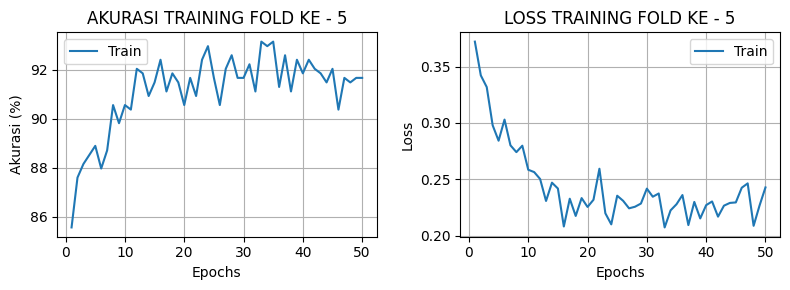



Predicted   0  1  2   3  4  5
Actual                       
0          10  0  0   0  0  0
1           0  7  2   0  0  1
2           0  0  9   0  0  1
3           0  0  0  10  0  0
4           0  0  0   0  9  1
5           0  0  2   0  0  8

Akurasi||Loss model : 88.33% || 0.29770 


K-Fold ... (6/10)
Training model ... (1/50) 	 Akurasi/Loss : 89.07 % / 0.25840 || Evaluasi model Akurasi/Loss : 28.33 % / 9.59810
Training model ... (2/50) 	 Akurasi/Loss : 89.81 % / 0.26867 || Evaluasi model Akurasi/Loss : 18.33 % / 12.32083
Training model ... (3/50) 	 Akurasi/Loss : 90.37 % / 0.24695 || Evaluasi model Akurasi/Loss : 16.67 % / 13.87512
Training model ... (4/50) 	 Akurasi/Loss : 92.22 % / 0.22117 || Evaluasi model Akurasi/Loss : 31.67 % / 4.67397
Training model ... (5/50) 	 Akurasi/Loss : 91.30 % / 0.24034 || Evaluasi model Akurasi/Loss : 36.67 % / 12.82637
Training model ... (6/50) 	 Akurasi/Loss : 91.11 % / 0.22254 || Evaluasi model Akurasi/Loss : 51.67 % / 1.74900
Training model ... (7

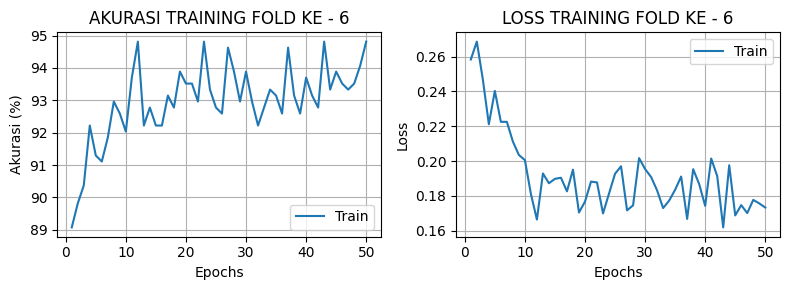



Predicted  0  1  2  3   4  5
Actual                      
0          9  0  0  0   1  0
1          0  8  1  0   0  1
2          0  1  5  0   0  4
3          0  0  0  9   1  0
4          0  0  0  0  10  0
5          0  0  0  2   0  8

Akurasi||Loss model : 81.67% || 0.56586 


K-Fold ... (7/10)
Training model ... (1/50) 	 Akurasi/Loss : 91.11 % / 0.24876 || Evaluasi model Akurasi/Loss : 23.33 % / 10.65183
Training model ... (2/50) 	 Akurasi/Loss : 91.48 % / 0.24728 || Evaluasi model Akurasi/Loss : 16.67 % / 30.60851
Training model ... (3/50) 	 Akurasi/Loss : 90.56 % / 0.26265 || Evaluasi model Akurasi/Loss : 16.67 % / 13.47942
Training model ... (4/50) 	 Akurasi/Loss : 91.48 % / 0.22075 || Evaluasi model Akurasi/Loss : 26.67 % / 6.09975
Training model ... (5/50) 	 Akurasi/Loss : 91.48 % / 0.21598 || Evaluasi model Akurasi/Loss : 16.67 % / 15.08311
Training model ... (6/50) 	 Akurasi/Loss : 92.04 % / 0.22454 || Evaluasi model Akurasi/Loss : 20.00 % / 6.53240
Training model ... (7/50) 	 

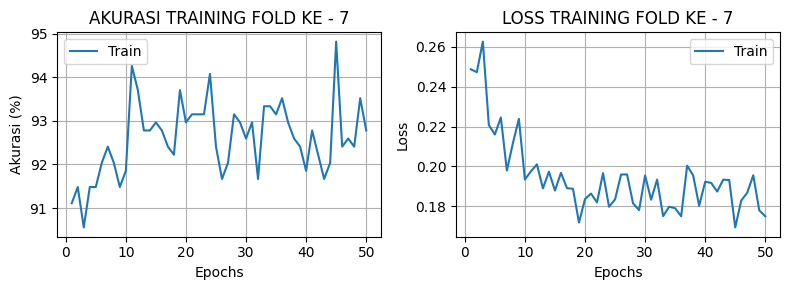



Predicted   0   1   2   3  4   5
Actual                          
0          10   0   0   0  0   0
1           0  10   0   0  0   0
2           0   0  10   0  0   0
3           0   0   0  10  0   0
4           0   0   0   1  9   0
5           0   0   0   0  0  10

Akurasi||Loss model : 98.33% || 0.07003 


K-Fold ... (8/10)
Training model ... (1/50) 	 Akurasi/Loss : 91.30 % / 0.21594 || Evaluasi model Akurasi/Loss : 16.67 % / 25.80734
Training model ... (2/50) 	 Akurasi/Loss : 91.11 % / 0.23207 || Evaluasi model Akurasi/Loss : 16.67 % / 13.11488
Training model ... (3/50) 	 Akurasi/Loss : 92.41 % / 0.21122 || Evaluasi model Akurasi/Loss : 23.33 % / 33.76874
Training model ... (4/50) 	 Akurasi/Loss : 92.59 % / 0.18885 || Evaluasi model Akurasi/Loss : 20.00 % / 37.19076
Training model ... (5/50) 	 Akurasi/Loss : 92.78 % / 0.20709 || Evaluasi model Akurasi/Loss : 20.00 % / 13.74562
Training model ... (6/50) 	 Akurasi/Loss : 93.89 % / 0.16806 || Evaluasi model Akurasi/Loss : 20.00 % / 13.

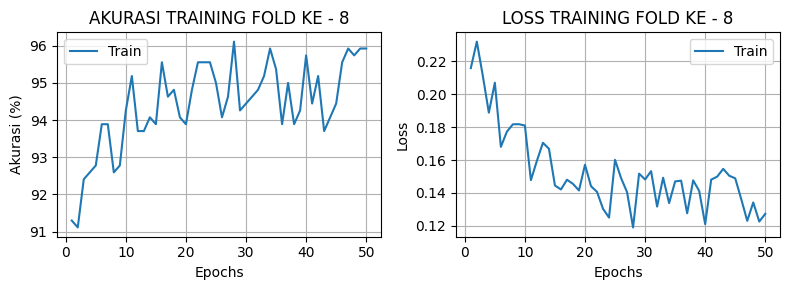



Predicted   0   1  2   3   4  5
Actual                         
0          10   0  0   0   0  0
1           0  10  0   0   0  0
2           0   0  8   0   0  2
3           0   0  0  10   0  0
4           0   0  0   0  10  0
5           0   0  2   0   0  8

Akurasi||Loss model : 93.33% || 0.13908 


K-Fold ... (9/10)
Training model ... (1/50) 	 Akurasi/Loss : 91.67 % / 0.18796 || Evaluasi model Akurasi/Loss : 16.67 % / 17.97230
Training model ... (2/50) 	 Akurasi/Loss : 93.52 % / 0.17196 || Evaluasi model Akurasi/Loss : 36.67 % / 1.62792
Training model ... (3/50) 	 Akurasi/Loss : 92.22 % / 0.20176 || Evaluasi model Akurasi/Loss : 16.67 % / 29.14306
Training model ... (4/50) 	 Akurasi/Loss : 94.63 % / 0.15774 || Evaluasi model Akurasi/Loss : 18.33 % / 16.68805
Training model ... (5/50) 	 Akurasi/Loss : 94.26 % / 0.15984 || Evaluasi model Akurasi/Loss : 51.67 % / 2.44292
Training model ... (6/50) 	 Akurasi/Loss : 93.89 % / 0.14832 || Evaluasi model Akurasi/Loss : 16.67 % / 8.67674
Train

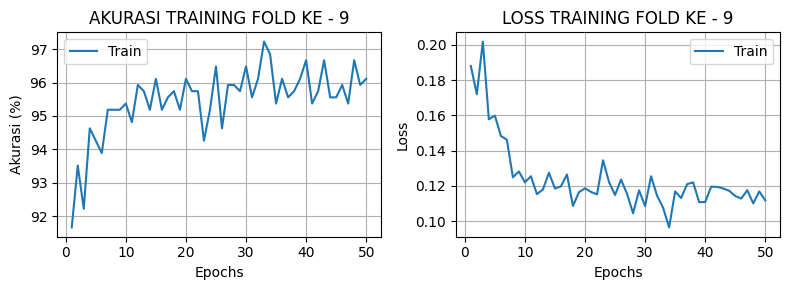



Predicted   0   1  2  3   4  5
Actual                        
0          10   0  0  0   0  0
1           0  10  0  0   0  0
2           0   0  8  0   0  2
3           0   0  0  6   4  0
4           0   0  0  0  10  0
5           0   0  2  0   0  8

Akurasi||Loss model : 86.67% || 0.27552 


K-Fold ... (10/10)
Training model ... (1/50) 	 Akurasi/Loss : 92.78 % / 0.20652 || Evaluasi model Akurasi/Loss : 18.33 % / 42.92855
Training model ... (2/50) 	 Akurasi/Loss : 89.63 % / 0.24386 || Evaluasi model Akurasi/Loss : 16.67 % / 17.75280
Training model ... (3/50) 	 Akurasi/Loss : 92.59 % / 0.20028 || Evaluasi model Akurasi/Loss : 30.00 % / 8.02100
Training model ... (4/50) 	 Akurasi/Loss : 92.96 % / 0.16680 || Evaluasi model Akurasi/Loss : 16.67 % / 17.40067
Training model ... (5/50) 	 Akurasi/Loss : 92.78 % / 0.17091 || Evaluasi model Akurasi/Loss : 20.00 % / 16.95952
Training model ... (6/50) 	 Akurasi/Loss : 94.44 % / 0.14952 || Evaluasi model Akurasi/Loss : 31.67 % / 13.69040
Training m

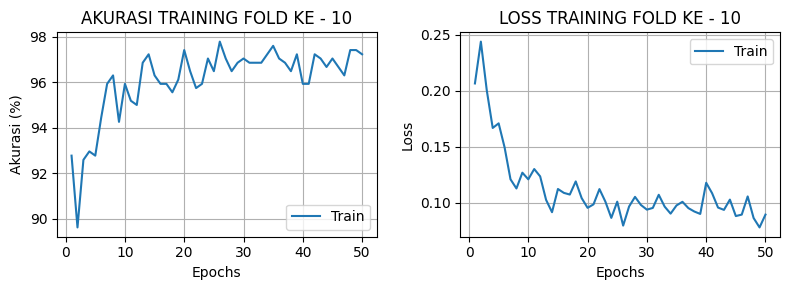



Predicted   0  1  2   3  4   5
Actual                        
0          10  0  0   0  0   0
1           0  9  0   0  1   0
2           0  0  9   0  0   1
3           0  0  0  10  0   0
4           0  0  0   1  9   0
5           0  0  0   0  0  10

Akurasi||Loss model : 95.00% || 0.17228 



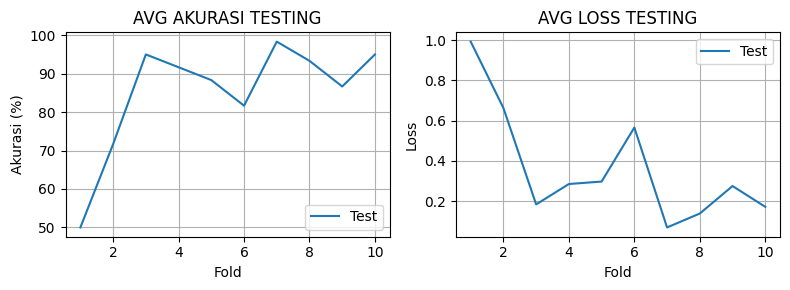



Performa rata - rata model Akurasi||Loss : 85.17% +- 14.60%||0.36453 +- 0.28851


In [ ]:
# Pseudocode
num_folds = 10
files_per_fold = len(datasets)/num_folds
#files_per_fold = 5

data_processor = DataProcessor(lokasi_data)
processed_datasets = data_processor.read_files(datasets[:int(files_per_fold)])

class_count = []
for i in range(len(processed_datasets)):
  class_count.append(processed_datasets[i]['class'])
labels = np.unique(class_count)
class_count = pd.DataFrame(class_count)
print(f"Total Validasi Class ({int(files_per_fold)} files per K-Fold):")
print(class_count.value_counts())


model = VariableCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("\n",model)

batch_size = 18
num_epochs = 50

avg_acc = []
avg_loss = []
for fold in range(num_folds):

    learning_rate = 0.001
    #criterion = nn.NLLLoss()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=1)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # Calculate start and end indices for the validation files
    start_idx = int(fold * files_per_fold)
    end_idx = int((fold + 1) * files_per_fold)

    validasi = datasets[start_idx:end_idx]
    training = datasets[:start_idx] + datasets[end_idx:]

    #data_processor = DataProcessor(lokasi_data)
    processed_validasi = data_processor.read_files(validasi)
    processed_training = data_processor.read_files(training)

    CustomDataset_validasi = CustomDataset(processed_validasi)
    CustomDataset_training = CustomDataset(processed_training)

    validasi_dataloader = DataLoader(CustomDataset_validasi, batch_size=int(len(processed_validasi)), collate_fn=my_collate_fn)
    #training_dataloader = DataLoader(CustomDataset_training, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)

    print(f"\nK-Fold ... ({fold+1}/{num_folds})")

    #train_model(model, criterion, optimizer, num_epochs, batch_size, device)

    #model.load_state_dict(torch.load("/content/drive/MyDrive/data/data_emg/models/bestmodel_var_cnn.mdl"))
    #test_loss, test_accuracy = evaluate_model(model, criterion, validasi_dataloader, device)
    test_loss, test_accuracy = train_eval_model(model, criterion, optimizer, num_epochs, batch_size, device)
    plot_loss_akurasi(num_epochs)
    print("\n")
    matrix()
    avg_acc.append(test_accuracy)
    avg_loss.append(test_loss)
    print(f"\nAkurasi||Loss model : {test_accuracy:.2f}% || {test_loss:.5f} \n")


plt.close('all')
fig = plt.figure(figsize=(8, 3))

plt.subplot(122)
x = np.array(range(1, num_folds+1))
plt.plot(x, avg_loss, label = 'Test')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.title('AVG LOSS TESTING')
plt.grid()
plt.legend()

plt.subplot(121)
plt.plot(x, avg_acc, label = 'Test')
plt.xlabel('Fold')
plt.ylabel('Akurasi (%)')
plt.title('AVG AKURASI TESTING')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

acc = torch.tensor(avg_acc).mean()
loss = torch.tensor(avg_loss).mean()
d_acc = torch.tensor(avg_acc).std()
d_loss = torch.tensor(avg_loss).std()

print(f"\n\nPerforma rata - rata model Akurasi||Loss : {acc:.2f}% +- {d_acc:.2f}%||{loss:.5f} +- {d_loss:.5f}")

In [ ]:
avg_acc

<IPython.core.display.Javascript object>

[50.0,
 71.66667175292969,
 95.00000762939453,
 91.66667175292969,
 88.33333587646484,
 81.66667175292969,
 98.33334350585938,
 93.33334350585938,
 86.66667175292969,
 95.00000762939453]

In [ ]:
avg_loss

<IPython.core.display.Javascript object>

[0.9923086166381836,
 0.6626338362693787,
 0.18432123959064484,
 0.2855401039123535,
 0.297697514295578,
 0.5658568143844604,
 0.07002723962068558,
 0.1390841156244278,
 0.2755189538002014,
 0.1722765564918518]

# 5. REFERENSI CODING
`IMPORT LIB`
* https://docs.python.org/3/library/glob.html
* https://docs.python.org/3/library/os.html
* https://docs.python.org/3/library/pickle.html
***
`PANDAS`
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_table.html
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iterrows.html
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mode.html
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html
***
`NUMPY`
* https://numpy.org/doc/stable/reference/generated/numpy.array.html
* https://numpy.org/doc/stable/reference/generated/numpy.zeros.html
* https://numpy.org/doc/stable/reference/generated/numpy.swapaxes.html
* https://numpy.org/doc/stable/reference/generated/numpy.unique.html
***
`PYTORCH`
* https://pytorch.org/docs/stable/tensors.html
* https://pytorch.org/docs/stable/generated/torch.mean.html
* https://pytorch.org/docs/stable/generated/torch.std.html
* https://pytorch.org/docs/stable/generated/torch.argmax.html
* https://pytorch.org/docs/stable/generated/torch.Tensor.cpu.html
* https://pytorch.org/docs/stable/generated/torch.Tensor.numpy.html
* https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html
* https://pytorch.org/docs/stable/generated/torch.Tensor.item.html
* https://pytorch.org/docs/stable/cuda.html
* https://pytorch.org/docs/stable/generated/torch.cuda.is_available.html
* https://pytorch.org/docs/stable/data.html
* https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset
* https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset
* https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
* https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split
* https://pytorch.org/docs/stable/nn.html
* https://pytorch.org/docs/stable/generated/torch.nn.Module.html
* https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters
* https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html
* https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
* https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
* https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html
* https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveMaxPool1d.html#adaptivemaxpool1d
* https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
* https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#flatten
* https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
* https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
* https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.train
* https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval
* https://pytorch.org/docs/stable/optim.html
* https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
* https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#reducelronplateau
* https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
* https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html
* https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html
* https://pytorch.org/docs/stable/generated/torch.no_grad.html
*
***
`MATPLOTLIB`
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.close.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.grid.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xlabel.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ylabel.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.title.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.tight_layout.html
***
`PICKLE`
* https://docs.python.org/3/library/pickle.html#pickle.dumps
* https://docs.python.org/3/library/pickle.html#pickle.load
***
`OS`
* https://docs.python.org/3/library/os.html#os.listdir
* https://docs.python.org/3/library/os.path.html#os.path.isfile